In [61]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression

In [45]:
ft_train = np.load("./processed_data/features_train.npy")
ft_test = np.load("./processed_data/features_test.npy")
lbl_train = np.load("./processed_data/labels_train.npy")
lbl_test = np.load("./processed_data/labels_test.npy")

## Finding the principal components that preserve the majority of the information

In [46]:
# get dimension of features
ft_train.shape

(4088, 19)

In [47]:
pca = PCA(n_components=19, svd_solver="full")
ft_train_8D = pca.fit_transform(ft_train)

In [48]:
evr = pca.explained_variance_ratio_

In [49]:
for i in range(1,19):
    print(f"{i} principle components, proportion of variance preserved: {evr[:i].sum()}")

1 principle components, proportion of variance preserved: 0.2487023656530115
2 principle components, proportion of variance preserved: 0.38373843208063985
3 principle components, proportion of variance preserved: 0.4929163065215028
4 principle components, proportion of variance preserved: 0.5992067703777036
5 principle components, proportion of variance preserved: 0.6988895191852877
6 principle components, proportion of variance preserved: 0.7770100833121601
7 principle components, proportion of variance preserved: 0.8373028006085648
8 principle components, proportion of variance preserved: 0.8778664663722281
9 principle components, proportion of variance preserved: 0.912142730494012
10 principle components, proportion of variance preserved: 0.9351370586072808
11 principle components, proportion of variance preserved: 0.9572307953075465
12 principle components, proportion of variance preserved: 0.9762697678043974
13 principle components, proportion of variance preserved: 0.992652296671

## Performing PCA

In [50]:
# seems like 10 principle components will do
pca = PCA(n_components=0.92, svd_solver="full")
ft_train_red = pca.fit_transform(ft_train)

In [51]:
ft_train_red.shape

(4088, 10)

In [52]:
pca = PCA(n_components=0.92, svd_solver="full")
ft_test_red = pca.fit_transform(ft_test)

In [53]:
ft_test_red.shape

(1022, 10)

---------------------------------------------------------------------------------------------
## Trying it out?

In [64]:

clf = Pipeline([
    ("pca", PCA()),
    ("lr", LogisticRegression(class_weight='balanced')) 
])
param_grid = [{
    "pca__n_components": [2,3,5,6,8,10,11,13,14,15],
    "lr__C": [0.001,0.003,0.005,0.01,0.03,0.05,0.1,0.3,0.5,1,2,3,3,4,5]
}]

gs = GridSearchCV(clf, param_grid, cv=3) 
gs.fit(ft_train, lbl_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('lr',
                                        LogisticRegression(class_weight='balanced'))]),
             param_grid=[{'lr__C': [0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1,
                                    0.3, 0.5, 1, 2, 3, 3, 4, 5],
                          'pca__n_components': [2, 3, 5, 6, 8, 10, 11, 13, 14,
                                                15]}])

In [65]:
gs.best_params_

{'lr__C': 0.001, 'pca__n_components': 5}

In [98]:
pca = PCA(n_components=5)
ft_train_red = pca.fit_transform(ft_train)

In [99]:
lr = LogisticRegression(class_weight='balanced', C=0.001)
lr.fit(ft_train_red, lbl_train)

LogisticRegression(C=0.001, class_weight='balanced')

accuracy = 0.7563600782778865
precision = 0.10980392156862745
recall = 0.56
f1 = 0.18360655737704917
ROC AUC score = 0.6632304526748971


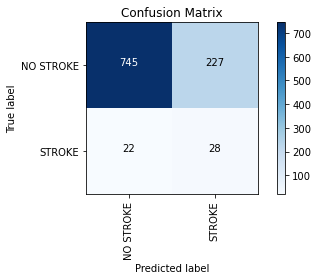

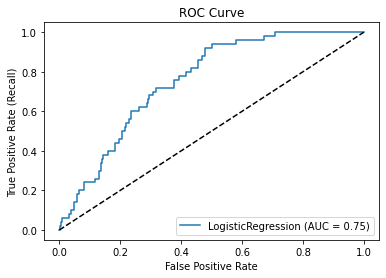

In [100]:
model_report_from(lr, pca.fit_transform(ft_test), lbl_test, [])

In [80]:
import itertools

import numpy as np
import pandas as pd
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

# Helper function that allows you to draw nicely formatted confusion matrices
def draw_confusion_matrix(y, yhat, classes):
    '''
        Draws a confusion matrix for the given target and predictions
        Adapted from scikit-learn and discussion example.
    '''
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)
    
    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()



def model_report_from(model, X_test, y_test, y_test_pred):
    if len(y_test_pred) != len(X_test):
        y_test_pred = model.predict(X_test)
        
    print(f"accuracy = {1 - sum(abs(y_test_pred - y_test))/len(y_test)}")
    print(f"precision = {precision_score(y_test, y_test_pred)}")
    print(f"recall = {recall_score(y_test, y_test_pred)}")
    print(f"f1 = {f1_score(y_test, y_test_pred)}")
    print(f"ROC AUC score = {roc_auc_score(y_test, y_test_pred)}")

    # display confusion matrix
    draw_confusion_matrix(y_test, y_test_pred, ["NO STROKE", "STROKE"])

    # draw ROC curve
    plot_roc_curve(model, X_test, y_test)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("ROC Curve")
    plt.ylabel("True Positive Rate (Recall)")
    plt.xlabel("False Positive Rate")
    plt.legend(loc="lower right")
    plt.show()
